In [77]:
# libraries
import numpy as np
import pandas as pd
import shap
import seaborn as sns 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, f1_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRFClassifier, XGBRFRegressor, plot_tree

import matplotlib.pyplot as plt

In [2]:
# read in data frames
election_38_df = pd.read_csv("data/merged/38_general_election.csv")
election_39_df = pd.read_csv("data/merged/39_general_election.csv")
election_40_df = pd.read_csv("data/merged/40_general_election.csv")
election_41_df = pd.read_csv("data/merged/41_general_election.csv")
election_42_df = pd.read_csv("data/merged/42_general_election.csv")
election_43_df = pd.read_csv("data/merged/43_general_election.csv")
election_44_df = pd.read_csv("data/merged/44_general_election.csv")

In [3]:
election_38_df.columns

Index(['Unnamed: 0', 'Political Entity', 'Recipient ID', 'Recipient',
       'Recipient last name', 'Recipient first name',
       'Political Party of Recipient', 'Electoral District', 'Electoral event',
       'Fiscal/Election date', 'Contributor City', 'Contributor Province',
       'Contributor Postal code', 'Contribution Received date',
       'Monetary amount', 'cleaned_district_name_x', 'ED_CODE',
       'Percentage of Votes Obtained /Pourcentage des votes obtenus',
       'won_election'],
      dtype='object')

In [4]:
# create a "metadata" df to help out

# REFS:
# https://laws-lois.justice.gc.ca/eng/acts/e-2.01/section-405-20040101.html#wb-cont
# finding all the election limits to normalize the amounts
# https://laws-lois.justice.gc.ca/eng/acts/E-2.01/PITIndex.html



election_caps_dict = {
    "38": 5000,
    "39": 5000,
    "40": 1000,
    "41": 1000,
    "42": 1500,
    "43": 1500,
    "44": 1500
}

election_years_dict = {
    "38": 2004,
    "39": 2006,
    "40": 2008,
    "41": 2011,
    "42": 2015,
    "43": 2019,
    "44": 2021
}

metadata_elections_df = pd.DataFrame({
    "election": election_caps_dict.keys(),
    "contribution_cap": election_caps_dict.values(),
    "election_year": election_years_dict.values()
})

metadata_elections_df

,election,contribution_cap,election_year
0,38,5000,2004
1,39,5000,2006
2,40,1000,2008
3,41,1000,2011
4,42,1500,2015
5,43,1500,2019
6,44,1500,2021


In [5]:
# pull in inflation CPIs for adjusting to inflation

cpi_df = pd.read_csv('data/cpi.csv')
cpi_df = cpi_df[cpi_df['Products and product groups'] == 'All-items'][['REF_DATE', 'VALUE']]

cpi_df.head()

,REF_DATE,VALUE
0,2004,104.7
1,2005,107.0
2,2006,109.1
3,2007,111.5
4,2008,114.1


In [6]:
# rebase the CPI to 2004 = 100, since the data is using 2002 = 100
base_2004_cpi = cpi_df.loc[cpi_df['REF_DATE'] == 2004]['VALUE'][0]
cpi_df['VALUE'] = cpi_df['VALUE']/base_2004_cpi*100
cpi_df.head()

,REF_DATE,VALUE
0,2004,100.000000
1,2005,102.196753
2,2006,104.202483
3,2007,106.494747
4,2008,108.978032


In [7]:
metadata_elections_df = metadata_elections_df.copy().merge(cpi_df, left_on='election_year', right_on='REF_DATE')
metadata_elections_df

,election,contribution_cap,election_year,REF_DATE,VALUE
0,38,5000,2004,2004,100.000000
1,39,5000,2006,2006,104.202483
2,40,1000,2008,2008,108.978032
3,41,1000,2011,2011,114.517670
4,42,1500,2015,2015,120.916905
5,43,1500,2019,2019,129.894938
6,44,1500,2021,2021,135.243553


In [ ]:
# setting up preprocessing for all the frames

columns_rename_map = {
    "Recipient ID": "recipient_id",
    "Political Party of Recipient": "political_party",
    "ED_CODE": "electoral_district", #use the code instead, need to remember to set this as categorical
    "Monetary amount": "monetary_amount",
    "Percentage of Votes Obtained /Pourcentage des votes obtenus": "percentage_vote"
}

def preprocess(df, election_number):
   
   # drop unneeded columns
   df = df.drop(columns=['Unnamed: 0', 'Political Entity', 'Electoral event', 'Fiscal/Election date', 
                        'Recipient last name', 'Recipient first name','Contributor City', 'Contributor Province', 
                        'Contributor Postal code', 'Contribution Received date', 'cleaned_district_name_x', 'Electoral District', 
                        'Recipient'], 
                errors='ignore')
    
   # remove any 0 monetary amounts - these are probably residuals from the non-monetary amounts, not relevant to our modelling here 
   df = df[df['Monetary amount'] != 0]

   # rename columns for consistency and ease 
   df = df.rename(columns=columns_rename_map, errors = 'ignore')

   # adjust for inflation, normalize to the contribution cap
   cpi = metadata_elections_df[metadata_elections_df['election'] == election_number]['VALUE'].iloc[0]
   cap = metadata_elections_df[metadata_elections_df['election'] == election_number]['contribution_cap'].iloc[0]

   df['monetary_amount'] = df['monetary_amount']/cap *cpi/100

   # add in election number
   df['election_number'] = election_number


   # groupby and agg
   df = df.groupby('recipient_id').agg(
      # aggregate functions 
      monetary_sum = pd.NamedAgg(column= 'monetary_amount', aggfunc="sum"), 
      num_donations = pd.NamedAgg(column= 'monetary_amount', aggfunc='count'),
      #monetary_mean = pd.NamedAgg(column= "monetary_amount", aggfunc = 'mean'),
      #monetary_std = pd.NamedAgg(column= 'monetary_amount', aggfunc= 'std'),
      #monetary_min = pd.NamedAgg(column= 'monetary_amount', aggfunc= 'min'),
      monetary_max = pd.NamedAgg(column= 'monetary_amount', aggfunc= 'max'),
      #num_max_donations = pd.NamedAgg(column='monetary_amount', aggfunc=lambda x: (x >= 0.5).sum()),

      # agg for the other columns
      political_party = pd.NamedAgg(column= 'political_party', aggfunc= 'first'),
      electoral_district = pd.NamedAgg(column = 'electoral_district', aggfunc= 'first'),
      percentage_vote = pd.NamedAgg(column = 'percentage_vote', aggfunc = 'first'),
      election_number = pd.NamedAgg(column = 'election_number', aggfunc = 'first'),
      won_election = pd.NamedAgg(column = 'won_election', aggfunc= 'first')

   ).reset_index()

   # calculate the total amount of donations within a district per election
   district_total = df.groupby(['electoral_district', 'election_number'])['monetary_sum'].transform('sum')
   df['district_share'] = df['monetary_sum']/district_total

   # calculated the percent of max donations a candidate hits
   #df['max_donation_pct'] = df['num_max_donations']/df['num_donations']
 
   # drop the recipent_id
   df = df.drop(columns= ['recipient_id'])
    
   return df

In [86]:
# check if recipient id is consistent across the years if needed

# process all the election dataframes, hold 44th back as the test dataset
election_38_processed_df = preprocess(election_38_df, "38")
election_39_processed_df = preprocess(election_39_df, "39")
election_40_processed_df = preprocess(election_40_df, "40")
election_41_processed_df = preprocess(election_41_df, "41")
election_42_processed_df = preprocess(election_42_df, "42")
election_43_processed_df = preprocess(election_43_df, "43")
election_44_processed_df = preprocess(election_44_df, "44")

test_df = election_44_processed_df

In [87]:
# stack the remaining frames together as the training set 

train_df = pd.concat([election_38_processed_df, election_39_processed_df, election_40_processed_df, 
           election_41_processed_df, election_42_processed_df, election_43_processed_df], axis= 0)

train_df

,monetary_sum,num_donations,monetary_max,political_party,electoral_district,percentage_vote,election_number,won_election,district_share
0,4.874148,35,0.863880,Conservative Party of Canada,10003.0,22.95,38,False,0.282819
1,11.655000,80,1.000000,Liberal Party of Canada,10003.0,62.56,38,True,0.676274
2,8.449500,62,0.200000,Liberal Party of Canada,10004.0,62.23,38,True,0.830867
3,4.724000,21,1.000000,Liberal Party of Canada,10005.0,46.77,38,True,0.490194
4,2.500000,22,0.360000,Conservative Party of Canada,10005.0,18.21,38,False,0.259417
...,...,...,...,...,...,...,...,...,...
28,91.942503,117,1.817663,Liberal Party of Canada,35117.0,36.30,43,False,1.000000
29,3.463865,7,0.865966,Conservative Party of Canada,24053.0,11.40,43,False,1.000000
30,0.766380,4,0.432983,Green Party of Canada,59005.0,7.80,43,False,1.000000
31,10.188093,23,3.901178,New Democratic Party,35103.0,28.90,43,False,1.000000


<Axes: >

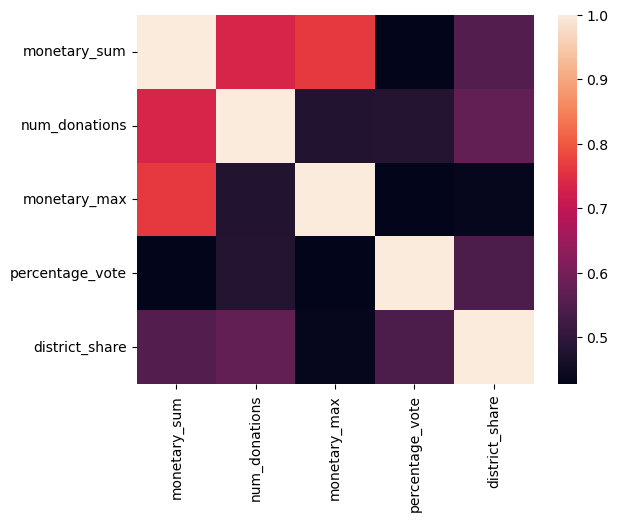

In [11]:
# add a corrplot
numerical_features = ['monetary_sum', 'num_donations', 'monetary_max', 'percentage_vote', 'district_share']
corr_vals = train_df[numerical_features].corr()

sns.heatmap(corr_vals)

In [ ]:
# build out classifier set, regression set for train/validation
y_train_classify_full = train_df['won_election']
X_train_classify_full = train_df.drop(columns=['won_election', 'percentage_vote'])
categorical_cols = ['political_party', 'electoral_district', 'election_number']
numeric_cols = X_train_classify_full.drop(columns=categorical_cols).columns.tolist()

# set up encoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_classify_full = X_train_classify_full.apply(pd.to_numeric, errors='coerce')



X_train_classify, X_valid_classify, y_train_classify, y_valid_classify = train_test_split(X_train_classify_full, y_train_classify_full)

y_test_classify = test_df['won_election']
X_test_classify = test_df.drop(columns=['won_election', 'percentage_vote'])
X_test_classify = X_test_classify.apply(pd.to_numeric, errors='coerce')

y_train_regression_full = train_df['percentage_vote']
X_train_regression_full = train_df.drop(columns=['won_election', 'percentage_vote'])
X_train_regression, X_valid_regression, y_train_regression, y_valid_regression = train_test_split(X_train_regression_full, y_train_regression_full)

y_test_regression = test_df['percentage_vote']
X_test_regression = test_df.drop(columns=['won_election', 'percentage_vote'])

In [88]:
# get X and y train/test
y_train_classify_full = train_df['won_election']
y_test_classify = test_df['won_election']

y_train_regression_full = train_df['percentage_vote']
y_test_regression = test_df['percentage_vote']

X_train_full = train_df.drop(columns=['won_election', 'percentage_vote'])
X_test_full = test_df.drop(columns=['won_election', 'percentage_vote'])

# encode categorical
categorical_cols = ['political_party', 'electoral_district', 'election_number']
numeric_cols = X_train_full.drop(columns=categorical_cols).columns.tolist()

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat_encoded = encoder.fit_transform(X_train_full[categorical_cols])
X_test_cat_encoded = encoder.transform(X_test_full[categorical_cols])

# convert to dataframe
encoded_cat_cols = encoder.get_feature_names_out(categorical_cols)

X_train_cat_df = pd.DataFrame(X_train_cat_encoded, columns=encoded_cat_cols, index=X_train_full.index)
X_test_cat_df = pd.DataFrame(X_test_cat_encoded, columns=encoded_cat_cols, index=X_test_full.index)

# combine with the numerical colmns
X_train_encoded = pd.concat([X_train_full[numeric_cols], X_train_cat_df], axis=1)
X_test_encoded = pd.concat([X_test_full[numeric_cols], X_test_cat_df], axis=1)

# numeric type enforcement (SHAP errors)
X_train_encoded = X_train_encoded.apply(pd.to_numeric, errors='coerce')
X_test_encoded = X_test_encoded.apply(pd.to_numeric, errors='coerce')

# train/test split
X_train_classify, X_valid_classify, y_train_classify, y_valid_classify = train_test_split(
    X_train_encoded, y_train_classify_full, random_state=42
)

X_train_regression, X_valid_regression, y_train_regression, y_valid_regression = train_test_split(
    X_train_encoded, y_train_regression_full, random_state=42
)

In [89]:
# pull in RF & XGBoost

bst = XGBRFClassifier(n_estimators=10, max_depth=2, learning_rate=1, objective='binary:logistic', enable_categorical = True)
bst.fit(X_train_classify, y_train_classify)

,learning_rate,1
,subsample,0.8
,colsample_bynode,0.8
,reg_lambda,1e-05
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bytree,None
,device,None


In [90]:
pred = bst.predict(X_valid_classify)
y_true = y_valid_classify.astype('int').values
f1_score(y_true, pred) 

0.4533333333333333

<Axes: >

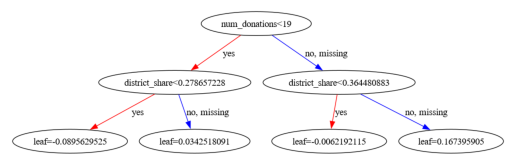

In [91]:
# matplotlib to plot the tree
plot_tree(bst)

In [18]:
def get_base_feature(col_name, original_features):
    for base in original_features:
        if col_name.startswith(base + '_'):
            return base
    return col_name

def create_importance_dataframe(features, importance):
    tree_metadata_df = pd.DataFrame({"feature": features, "importance": importance})
    tree_metadata_df['original_category'] = tree_metadata_df['feature'].apply(lambda x: get_base_feature(x,['political_party', 'electoral_district', 'election_number']))
    tree_metadata_df = tree_metadata_df.groupby('original_category')['importance'].sum().reset_index()
    
    return tree_metadata_df

In [92]:
# grid search CV for hyperparameter tuning + cv at the same time
bst_cv = XGBRFClassifier(objective='binary:logistic', enable_categorical = True)

clf_bst = GridSearchCV(
    bst_cv,
    {"n_estimators": [50, 100, 150, 200], "max_depth": [4,6, 8], "learning_rate": [1, 5], "grow_policy": ["depthwise", "lossguide"]},
    verbose = 1,
    scoring= 'f1'
)

clf_bst.fit(X_train_classify_full, y_train_classify_full)
print(clf_bst.best_score_)
print(clf_bst.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
0.5898590539925654
{'grow_policy': 'depthwise', 'learning_rate': 5, 'max_depth': 8, 'n_estimators': 50}


In [94]:
bst_classify_best = XGBRFClassifier(objective='binary:logistic', enable_categorical = True, 
                            max_depth = 8, learning_rate = 5, n_estimators = 50, grow_policy = 'depthwise' )
bst_classify_best.fit(X_train_classify_full, y_train_classify_full)

pred = bst_classify_best.predict(X_test_encoded)
y_true = y_test_classify.astype('int').values
f1_score(y_true, pred) 

0.578125

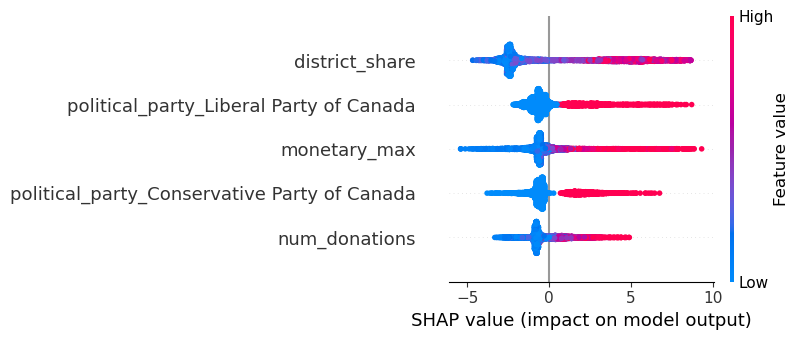

In [96]:
explainer = shap.Explainer(clf_bst.best_estimator_)
shap_values = explainer(X_train_classify_full)
shap.summary_plot(shap_values, X_train_classify_full, max_display=5)

## Regression Trees

In [101]:
xgb_reg = XGBRFRegressor(n_estimators=2, max_depth=2, learning_rate=1,enable_categorical = True)
xgb_reg.fit(X_train_regression, y_train_regression)

,learning_rate,1
,subsample,0.8
,colsample_bynode,0.8
,reg_lambda,1e-05
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bytree,None
,device,None


In [ ]:
pred = xgb_reg.predict(X_valid_regression)


202.54047163177287

In [ ]:
pred = xgb_reg.predict(X_valid_regression)
mean_absolute_error(y_valid_regression, pred)

10.827011799530789

In [105]:
reg_cv = XGBRFRegressor(enable_categorical = True)

clf_reg = GridSearchCV(
    reg_cv,
    {"n_estimators": [25, 50, 100, 150], "max_depth": [4,6, 8], "learning_rate": [1, 5], "grow_policy": ["depthwise", "lossguide"]},
    verbose = 1, 
    scoring = 'neg_mean_absolute_error'
)

clf_reg.fit(X_train_regression_full, y_train_regression_full)
print(clf_reg.best_score_)
print(clf_reg.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
-8.988338991808558
{'grow_policy': 'depthwise', 'learning_rate': 1, 'max_depth': 8, 'n_estimators': 25}


In [107]:
xgb_reg_best = XGBRFRegressor(enable_categorical = True, max_depth = 8, learning_rate = 1, n_estimators = 25, grow_policy = 'depthwise')
xgb_reg_best.fit(X_train_regression_full, y_train_regression_full)

pred = xgb_reg_best.predict(X_test_encoded)
mean_absolute_error(y_test_regression, pred)

11.839575557375518

In [26]:
create_importance_dataframe(X_train_regression_full.columns, clf_reg.best_estimator_.feature_importances_)

,original_category,importance
0,district_share,0.157425
1,election_number,0.113962
2,electoral_district,0.108228
3,monetary_max,0.017419
4,monetary_sum,0.005859
5,num_donations,0.035971
6,political_party,0.561137


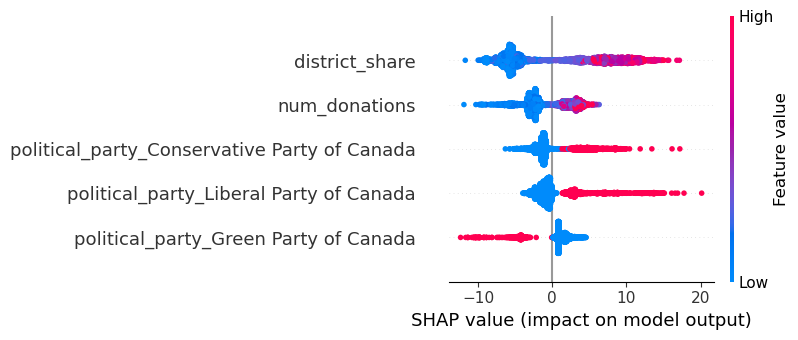

In [108]:
explainer = shap.Explainer(clf_reg.best_estimator_)
shap_values = explainer(X_train_regression_full)
shap.summary_plot(shap_values, X_train_regression_full, max_display=5)